In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
import bbi

In [1]:
import cooltools.api.snipping
#!cat {cooltools.api.snipping.__file__} | tail

In [3]:
# ignore log10(0) warnings
warnings.simplefilter("ignore", RuntimeWarning)

## Set plotting parameters

In [4]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 22,
                     'ytick.labelsize': 22,
                     'axes.labelsize':22,
                     'font.size': 22})

## Get chromosome arms

In [5]:
hg19_chromsizes = bf.fetch_chromsizes('hg19')
hg19_cens = bf.fetch_centromeres('hg19')
hg19_arms = bf.make_chromarms(hg19_chromsizes, hg19_cens)

## Upload cis and trans scsHi-C cooler files

In [6]:
# Define the window of interest (one-sided)
flank = 500000

# Define the resolution of the Hi-C data 
resolution = 10000

In [7]:
perturbation = 'WT'

# Load scsHi-C data based on the variable specified above (flank and resolution)
clrs = {rType:
        cooler.Cooler(
            f'/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/G2.fc_1_2_3_4.wOldG2.{rType}.1000.mcool::/resolutions/{resolution}')
        for rType in ["cis", "trans"]
        }

## Fix the sorting of the hg_19 arms to match coolers 

In [8]:
hg19_arms.chrom = hg19_arms.chrom.astype("category")
hg19_arms.chrom = hg19_arms.chrom.cat.set_categories(clrs["trans"].chromnames)
hg19_arms = hg19_arms.sort_values(["chrom","start"])
hg19_arms.reset_index(inplace = True, drop = True)

## Calculate expected Hi-C values

In [9]:
# Calculate expected values 
expClrs = {interType:
       cooltools.expected_cis (clrs[interType], view_df=hg19_arms, smooth = False, aggregate_smoothed=False, nproc=2, chunksize=1_000_000)
       for interType in ["cis", "trans"]
      }

## Upload SMC3 without Sororin peaks

In [10]:
center = 'SMC3_wo_Sororin'
smc3_wo_sororin = pd.read_csv("/groups/gerlich/experiments/Experiments_005700/005784/data/signal_peak_classification/smc3_wo_sororin.bed", 
                                sep = "\t")

smc3_wo_sororin

,chrom,start,end,length,mid,SMC3,Sororin
0,chr1,793102,793758,656,793430,0.166118,0.090913
1,chr1,805255,805437,182,805346,0.165794,0.064613
2,chr1,824997,825153,156,825075,0.001243,0.032140
3,chr1,873361,874093,732,873727,0.213029,0.020669
4,chr1,950664,951140,476,950902,0.272368,0.076408
...,...,...,...,...,...,...,...
13843,chrX,154215355,154216046,691,154215700,0.124045,-0.000317
13844,chrX,154277189,154277846,657,154277517,0.230675,0.042113
13845,chrX,154285222,154286364,1142,154285793,0.470423,0.079979
13846,chrX,154314458,154315341,883,154314899,0.332665,-0.029144


## Generate and plot observed over expected pile-ups centered at SMC3 peaks

In [11]:
# generate observed over expected Hi-C pile-ups
matricesObsExp = {}
for rType in ["cis", "trans"]:
    snippets = cooltools.pileup(clrs[rType], smc3_wo_sororin, view_df=hg19_arms, expected_df=expClrs[rType], flank=flank)
    matrix = np.nanmean(snippets, axis=0)
    matricesObsExp [rType] = matrix

In [12]:
# set ticks parameters
ticks_pixels = np.linspace(0, flank*2//resolution, 3)
ticks_kbp = (((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int))

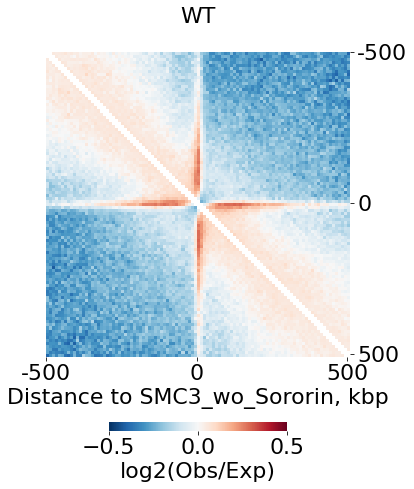

In [18]:
# plot observed over expected Hi-C pile-ups
f,ax = plt.subplots(figsize=(8, 8))
ax.set_title(f'{perturbation}\n', fontsize = 22)

# Plot +Old-Old (CompRef) map in the upper right sector
cis = np.log2(matricesObsExp['cis'])
im = sns.heatmap(cis, ax=ax,
            cmap=mpl.cm.get_cmap('RdBu_r'), vmin=-0.5, vmax=0.5,
            square=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.4, 'label':'log2(Obs/Exp)'},
            xticklabels=False,
            yticklabels=False)


ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Distance to {center}, kbp')
plt.show();

In [2]:
resDir = "/groups/gerlich/experiments/Experiments_005700/005784/results/signal_peak_classification/pileups/"
#f.savefig (os.path.join(resDir, f"hic_cis_obs_exp_{perturbation}_at_{center}_{resolution/1000}_window_{flank/1000}_res.png"), bbox_inches="tight", transparent=True)
#f.savefig (os.path.join(resDir, f"hic_cis_obs_exp_{perturbation}_at_{center}_{resolution/1000}_window_{flank/1000}_res.pdf"), bbox_inches="tight", transparent=True)

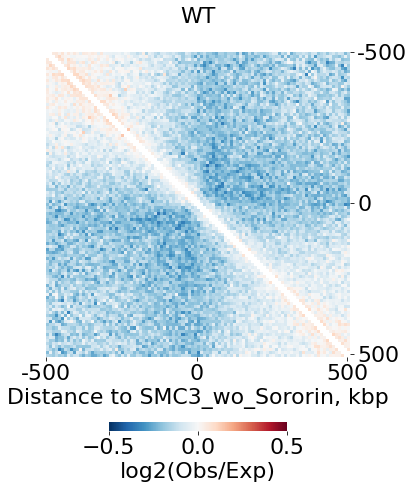

In [20]:
# plot observed over expected Hi-C pile-ups
f,ax = plt.subplots(figsize=(8, 8))
ax.set_title(f'{perturbation}\n', fontsize = 22)

# Plot +Old-Old (CompRef) map in the upper right sector
trans = np.log2(matricesObsExp['trans'])
im = sns.heatmap(trans, ax=ax,
            cmap=mpl.cm.get_cmap('RdBu_r'), vmin=-0.5, vmax=0.5,
            square=True,
            cbar_kws={'orientation':'horizontal', 'shrink':0.4, 'label':'log2(Obs/Exp)'},
            xticklabels=False,
            yticklabels=False)


ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_kbp)
ax.set_yticks(ticks_pixels)
ax.yaxis.tick_right()
ax.set_yticklabels(ticks_kbp)
ax.set_xlabel(f'Distance to {center}, kbp')
plt.show();

In [3]:
#f.savefig (os.path.join(resDir, f"hic_trans_obs_exp_{perturbation}_at_{center}_{resolution/1000}_window_{flank/1000}_res.png"), bbox_inches="tight", transparent=True)
#f.savefig (os.path.join(resDir, f"hic_trans_obs_exp_{perturbation}_at_{center}_{resolution/1000}_window_{flank/1000}_res.pdf"), bbox_inches="tight", transparent=True)